In [1]:
# Import the required modules.
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import corner

from astropy.cosmology import Planck18 as cosmo    # Import a different cosmology as required.

from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric.sfzh import SFH, ZH, generate_sfzh
from synthesizer.parametric.galaxy import Galaxy
from unyt import Myr,Gyr    # Import additonal units as required.
from synthesizer.igm import Madau96, Inoue14

import bagpipes as pipes

ModuleNotFoundError: No module named 'corner'

## Producing synthetic observations with Synthesizer

In [2]:
grid_name = "test_grid"
grid_dir = "../synthesizer/tests/test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)
print(grid)

In [3]:
# Select the filters to generate synthetic observations for. Use the NIRCam filters from CEERS.
filter_codes = [f'JWST/NIRCam.{f}' for f in ['F115W', 'F150W','F200W', 'F277W', 'F356W', 'F410M', 'F444W']]
fc = FilterCollection(filter_codes, new_lam=grid.lam)

In [4]:
# Generate a constant metal enrichment history.

#-----------------------------------------
log10z = -2.0    # Change the metalicity.
#-----------------------------------------

Z_p = {'log10Z': log10z}
Zh = ZH.deltaConstant(Z_p)
print(Zh)

----------
SUMMARY OF PARAMETERISED METAL ENRICHMENT HISTORY
<class 'synthesizer.parametric.sfzh.ZH.deltaConstant'>
log10Z: -2.0
----------



----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class 'synthesizer.parametric.sfzh.SFH.Exponential'>
tau: 100 Myr
max_age: 200 Myr
median age: 69.00 Myr
mean age: 99.50 Myr
----------

----------
SUMMARY OF BINNED SFZH
median age: 71.87 Myr
mean age: 99.89 Myr
mean metallicity: 0.0080
----------



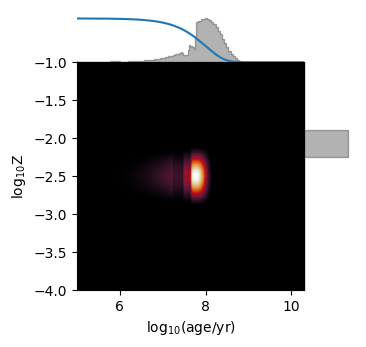

In [5]:
# Generate an exponential SFH.

#------------------------------------------------------------------------
tau = 100 * Myr    # Change the timescale of SFR decrease.
max_age = 200 * Myr    # Change the time since SF began. 
stellar_mass = 1E8    # Change the stellar mass to be generated [M_sol].
#------------------------------------------------------------------------

sfh_p = {'tau': tau, 'max_age': max_age}    # Use 'unyt' to define units.
sfh = SFH.Exponential(sfh_p) 
print(sfh)

# Bin with the enrichment history.
sfhz = generate_sfzh(grid.log10age, grid.metallicity, sfh, Zh, stellar_mass=stellar_mass)
print(sfhz)
sfhz.plot()
plt.show()

In [6]:
# Create a galaxy object from the binned SF and enrichment history.
galaxy = Galaxy(sfhz)

# Generate spectra using the pacman dust model (complex).

#------------------------------------------------------------------
Av = 0.5    # Change the absolute attenuation in the V band [mag].
#------------------------------------------------------------------

sed = galaxy.get_spectra_pacman(grid, fesc=0.5, fesc_LyA=0.5, tau_v=Av/1.086)

# Calculate the observed frame spectra based on assumed cosmology and IGM treatment.

#-------------------------------------------------------
z = 8    # Change the observed redshift of the galaxy.
igm = Madau96()    # Chnage the treatment of the IGM.
cosmology = cosmo    # Change the assumed cosmology.
#-------------------------------------------------------

sed.get_fnu(cosmology, z, igm=igm)

In [7]:
# Measure the broadband fluxes.
fluxes = sed.get_broadband_fluxes(fc)

for filter, flux in fluxes.items():
    print(f'{filter}: {flux:.2f}')

JWST/NIRCam.F115W: 5.64 nJy
JWST/NIRCam.F150W: 7.52 nJy
JWST/NIRCam.F200W: 7.26 nJy
JWST/NIRCam.F277W: 6.62 nJy
JWST/NIRCam.F356W: 8.04 nJy
JWST/NIRCam.F410M: 8.39 nJy
JWST/NIRCam.F444W: 9.55 nJy


emergent


/Users/jt458/syn_bagpipes/synthesizer/synthesizer/igm.py:206: RuntimeWarning: overflow encountered in exp
  t = np.exp(-tau)


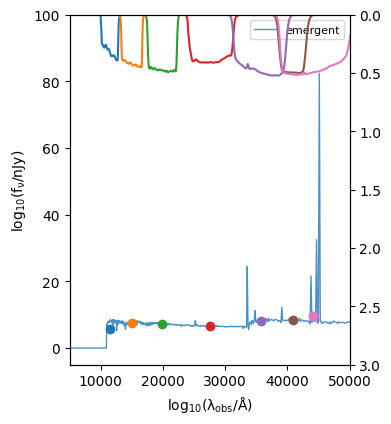

In [8]:
# Plot the observed spectra and the measured broadband fluxes.
fig, ax = galaxy.plot_observed_spectra(cosmo, z, fc=fc, spectra_to_plot=['emergent'])
ax.set_xlim(5000,50000)
ax.set_ylim(-5,100)
plt.show()

In [9]:
# Convert fluxes to micro jansky for use in BAGPIPES.
fluxes = np.array(list(fluxes.values()))/1e3

# Generate percentage errors on fluxes.

#---------------------------------------------------------------------
error = 0.05    # Change the percentage error on the measured fluxes.
#---------------------------------------------------------------------

errors = fluxes*error

# Add gaussian noise to the fluxes based on the error values.
fluxes = normal(fluxes,errors)

## Recovering model spectra with BAGPIPES

In [10]:
# Defining the same set of filters, in the same order.
# These should be downloaded from the SVO Filter Service and placed in '/bagpipes/filters'.
CEERS_filters = ["filters/JWST_NIRCam.F115W.dat",
                    "filters/JWST_NIRCam.F150W.dat",
                    "filters/JWST_NIRCam.F200W.dat",
                    "filters/JWST_NIRCam.F277W.dat",
                    "filters/JWST_NIRCam.F356W.dat",
                    "filters/JWST_NIRCam.F410M.dat",
                    "filters/JWST_NIRCam.F444W.dat",
                    ]

In [11]:
# Bagpipes needs a function that accepts an ID and returns corresponding photometry. 
# Creating a dummy function that just put the photometry into the correct form.

def get_photometry(ID, fluxes = fluxes, errors = errors):

    photometry = np.c_[fluxes, errors]

    return photometry

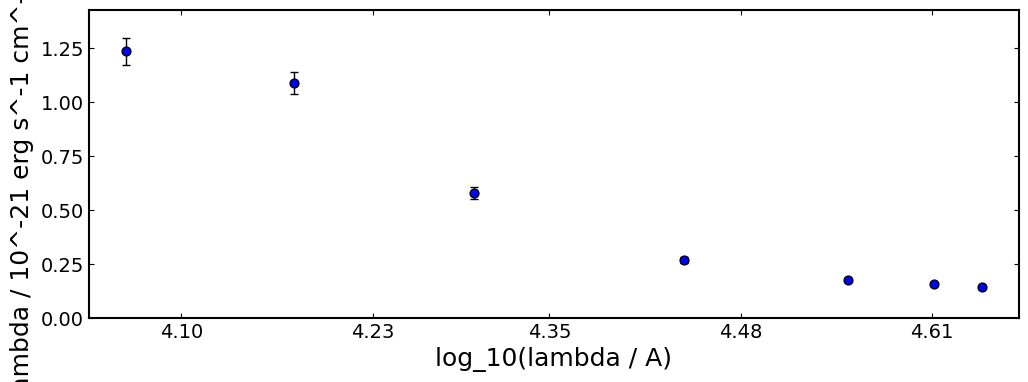

In [12]:
# Plot the measured photometry as an SED.
galaxy = pipes.galaxy("1", get_photometry, spectrum_exists=False, filt_list=CEERS_filters)
fig = galaxy.plot()

In [13]:
# Define the parameters to be used in the fit.
# A single value fixes the value, a range sets the lower and upper bounds.
# The parameters used here are taken from Austin et al. (2023) looking for high-redhisft galaxies.

fit_info = {}                   

# Dust attenuation law.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,6)    # Absolute attenuation in the V band in magnitudes.          
fit_info["dust"] = dust

# SFH:
# Exponential.
exponential = {}
exponential["massformed"] = (5,12)    # Log_10 total stellar mass formed in Solar masses.
exponential["metallicity"] = (1e-4,1)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.
exponential["age"] = (0,15)    # Time since star formation began in Gyr.
exponential["tau"] = (0.01,15)    # Timescale of exponential decrease in Gyr.
#exponential["tauprior"] = "log_10"    # Add priors using component["parameterprior"] = "<prior>".
fit_info['exponential'] = exponential

# Nubular:
nebular = {}
nebular["logU"] = -2    # Log_10 of the ionization parameter. Fixed as Synthesizer assumes -2, the bagpipes upper limit.
fit_info["nebular"] = nebular

# Redshift.
fit_info["redshift"] = z    # Fixed redshift to true value.

In [14]:
# Fit the model to the measured photometry.
# This will create a file called <ID>.h5 in "bagpipes/pipes/posterior". 
# If you are rerunning with the same ID, delete the file first or it will load the previous result. Or set 'run' to a different name.

# If this begins to throw a lot of errors, restart the kernel quickly or it will make the code unresponsive.
# This appears to happen if you choose an invalid range of parameters.
# "MultiNest Warning!" is fine.
fit = pipes.fit(galaxy, fit_info, run = 'fixed_z')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the pr

In [15]:
# Print the fitted values.
fit._print_results()

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.031      0.095      0.220
exponential:age                0.102      0.153      0.206
exponential:massformed         7.934      8.029      8.120
exponential:metallicity        0.051      0.854      0.960
exponential:tau                2.679      7.656     12.744




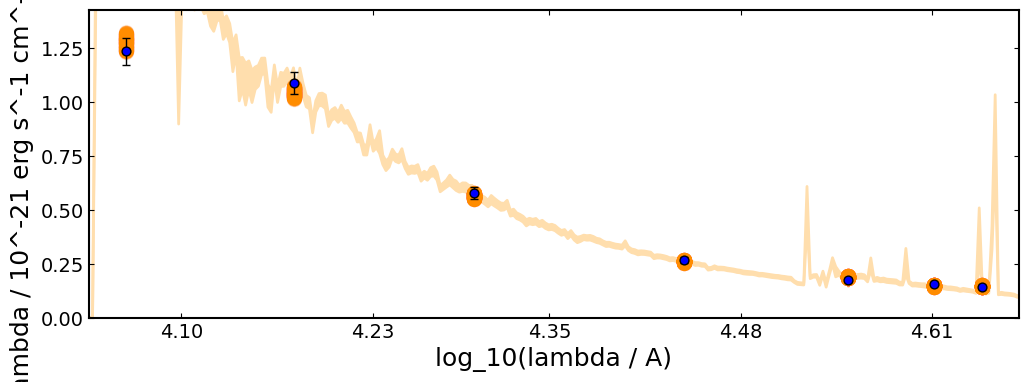

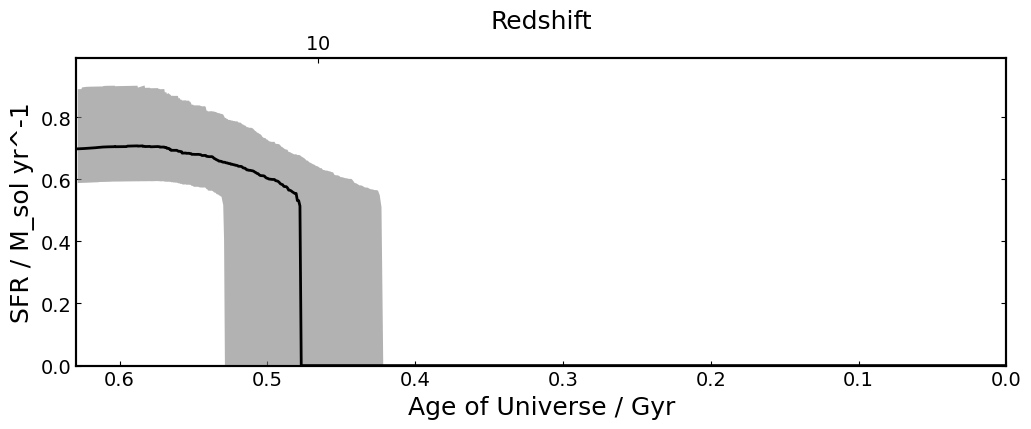

In [16]:
# Can use built in functions to plot SEDs, SFHs and corner plots.
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)

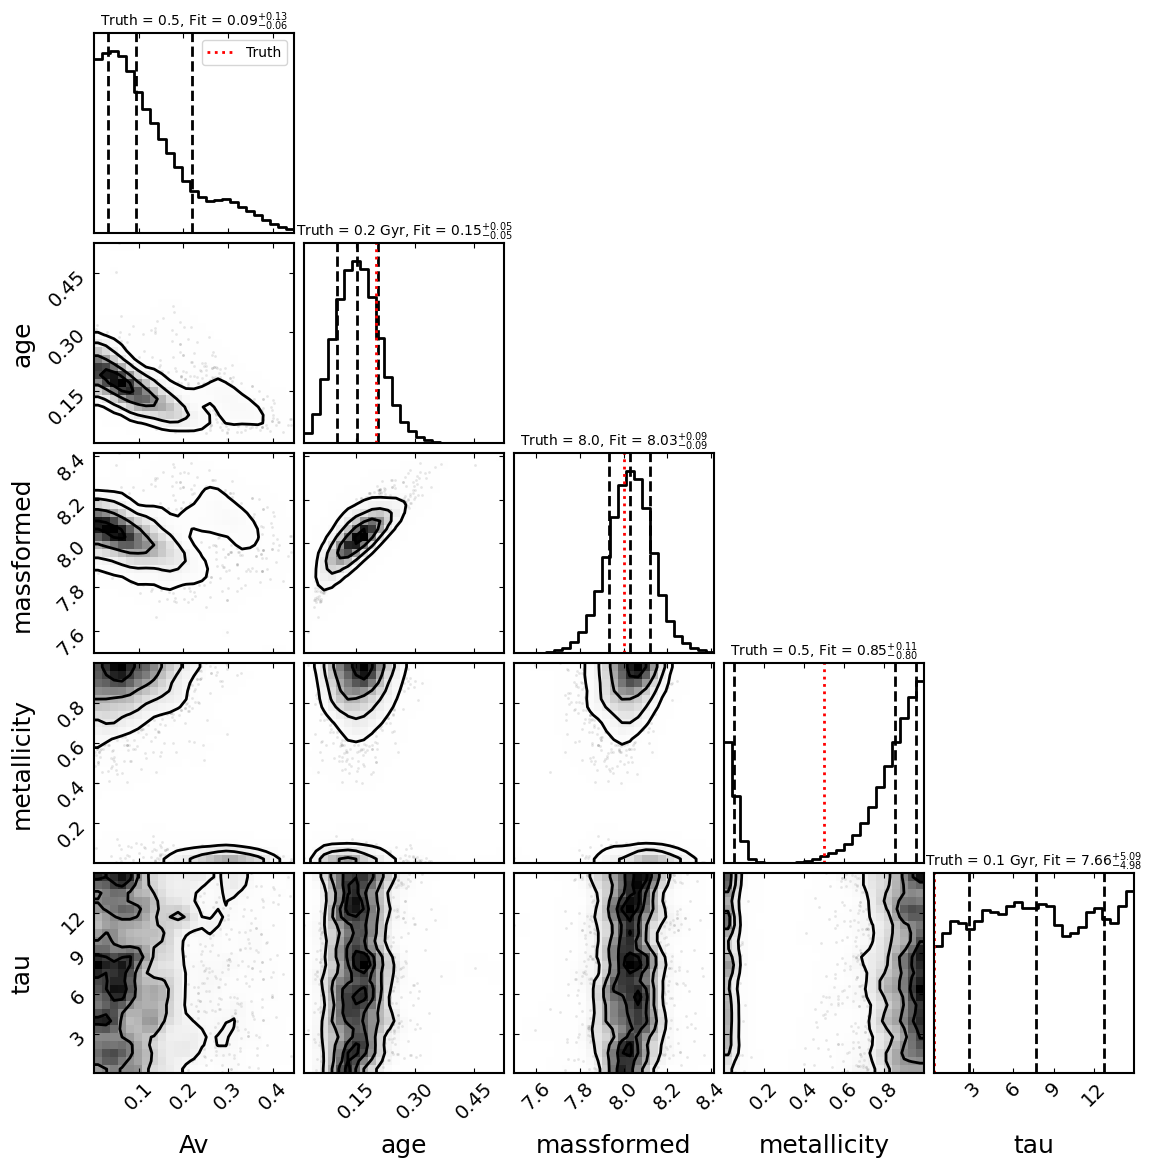

In [17]:
# Or write your own function if you want more freedom.

samples = np.copy(fit.posterior.samples2d)

truth = [Av,max_age.to(Gyr),np.log10(stellar_mass),(10**log10z)/0.02,tau.to(Gyr)]
titles = ['Truth = '+str(value)+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params]

# Make the corner plot
fig= corner.corner(samples, labels=labels, titles = titles,quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 10},
                    smooth=1., smooth1d=1., bins=25)

axes = [0,6,12,18,24]
for value, axis in zip(truth,axes):
    fig.axes[axis].axvline(value, color = 'red', linestyle = ':',label = 'Truth')
    fig.axes[0].legend()

plt.show()
plt.close(fig)

In [18]:
# Lets try fitting without knowing the redshift, as is often the case.

fit_info["redshift"] = (0,10)

fit = pipes.fit(galaxy, fit_info, run = 'free_z')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            3  is converging towards the edge of the prior.
 Parameter            2  of mode            3  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            3  is converging towards the edge of the prior.
 Parameter            2  of mode            3  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            3  is converging towards the edge of the prior.
 Parameter            2  of mode            3  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode     

In [19]:
# Print the fitted values.
fit._print_results()

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.014      0.044      0.080
exponential:age                0.122      0.154      0.192
exponential:massformed         7.935      8.022      8.081
exponential:metallicity        0.675      0.866      0.948
exponential:tau                2.196      5.936     10.806
redshift                       8.100      8.175      8.240




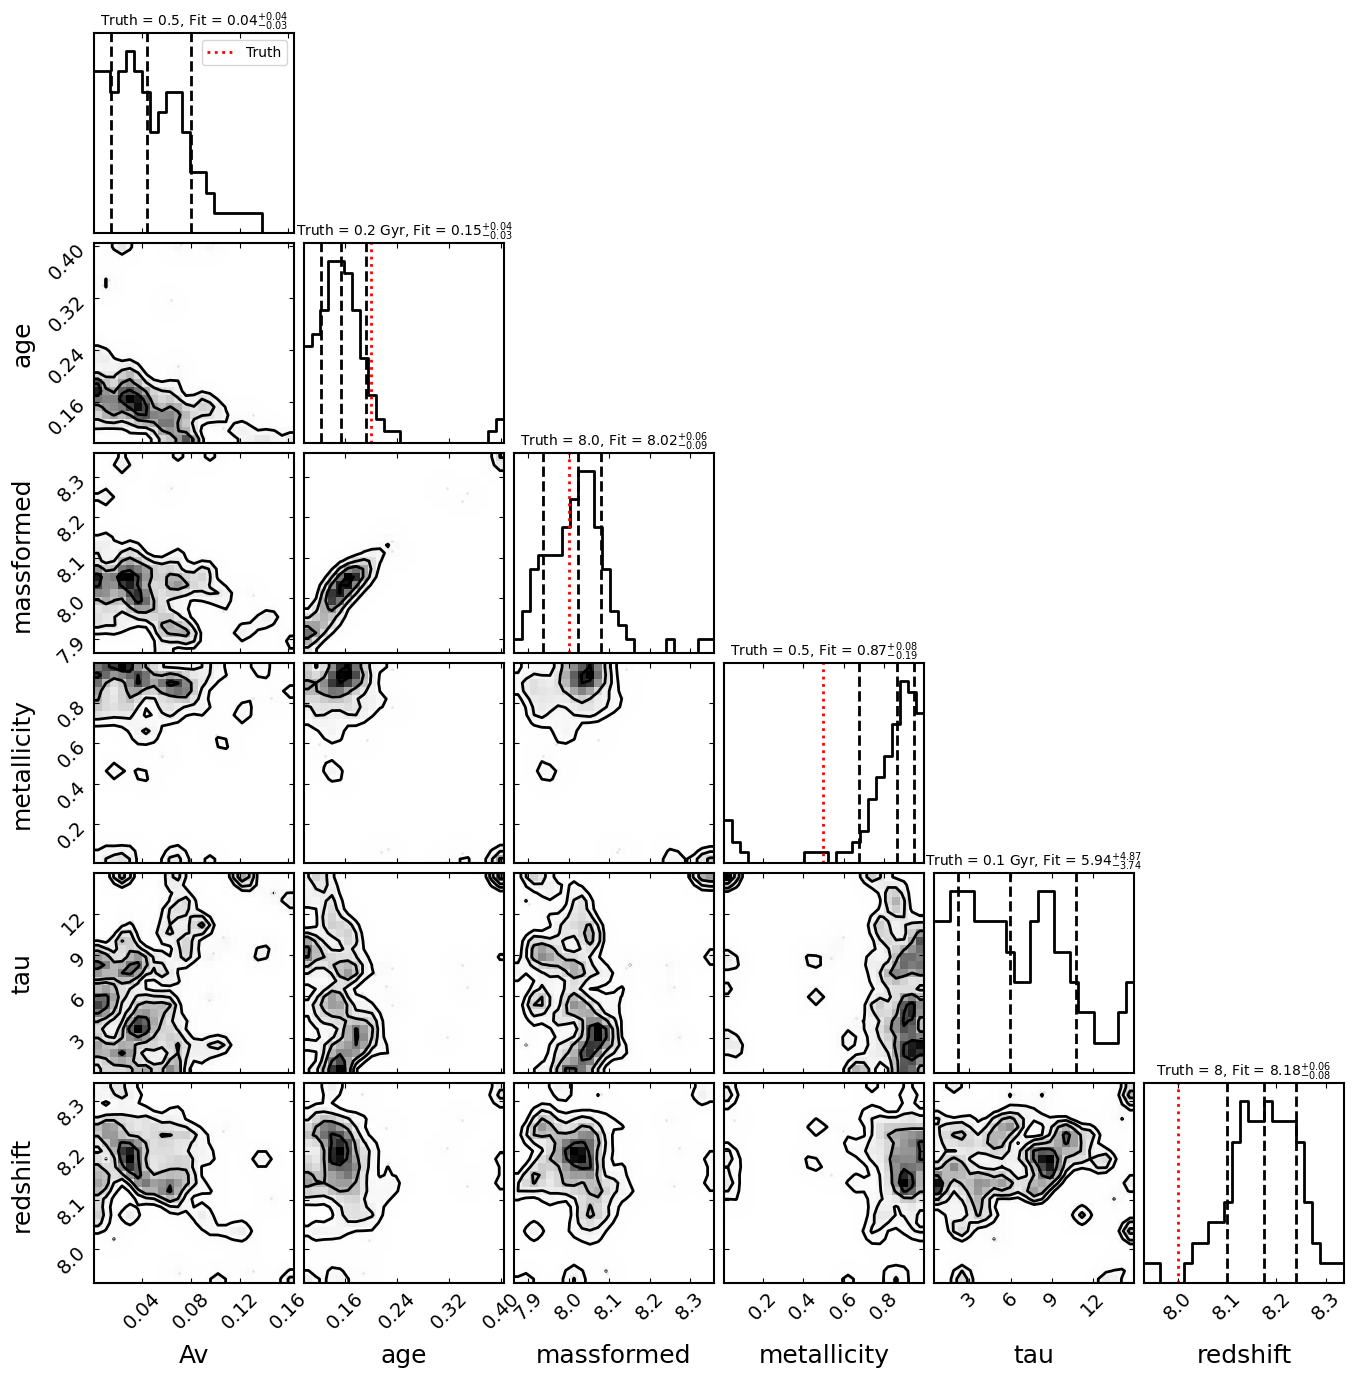

In [20]:
samples = np.copy(fit.posterior.samples2d)

truth = [Av,max_age.to(Gyr),np.log10(stellar_mass),(10**log10z)/0.02,tau.to(Gyr),z]
titles = ['Truth = '+str(value)+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params[:-1]]+['redshift']

# Make the corner plot
fig= corner.corner(samples, labels=labels, titles = titles,quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 10},
                    smooth=1., smooth1d=1., bins=25)

axes = [0,7,14,21,28,35,42]
for value, axis in zip(truth,axes):
    fig.axes[axis].axvline(value, color = 'red', linestyle = ':',label = 'Truth')
    fig.axes[0].legend()

plt.show()
plt.close(fig)